In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import gaussian_filter

def apply_filter_to_nifti_image(img_data):
    # Load the NIfTI image
    sigma = 1.0
    # Get the image data
    # Apply Gaussian filter to each slice
    filtered_slices = np.zeros_like(img_data)
    skull_stripped_slices = np.zeros_like(img_data)

    # Define the dimensions of the ROI
    roi_size = 244

    # Define CLAHE parameters
    clahe_slices = np.zeros_like(img_data)
    clip_limit = 1
    tile_grid_size = (8, 8)

    for i in range(img_data.shape[2]):  # Assuming the slice dimension is the third dimension
        filtered_slices[:, :, i] = gaussian_filter(img_data[:, :, i], 0.2)
        slice_data = filtered_slices[:, :, i]
        threshold_value=1
        # Check if slice is empty before skull stripping
            # If the slice is empty, skip skull stripping and store the original slice

            # Convert slice data to 8-bit unsigned integer format
        slice_data_uint8 = cv2.normalize(slice_data, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Skull stripping
        gray = slice_data_uint8
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        if ret > 0:

            colormask = np.zeros_like(slice_data_uint8, dtype=np.uint8)
            colormask[thresh != 0] = 255  # Set non-zero threshold values to 255
            colormask_bgr = cv2.cvtColor(colormask, cv2.COLOR_GRAY2BGR)  # Convert to BGR color format
            colormask_bgr[thresh == 0] = [0, 0, 0]  # Set background pixels to black
            blended = cv2.addWeighted(cv2.cvtColor(slice_data_uint8, cv2.COLOR_GRAY2BGR), 0.7, colormask_bgr, 0.1, 0)
            ret, markers = cv2.connectedComponents(thresh)

            # Get the area taken by each component. Ignore label 0 since this is the background.
            marker_area = [np.sum(markers == m) for m in range(1, np.max(markers) + 1)]

            # Set thresholds for minimum area and minimum brain content proportion

            if not marker_area:

                # If no brain area is detected, area is too small, or brain content proportion is too low,
                # skip skull stripping and use the original slice
                skull_stripped_slices[:, :, i] = filtered_slices[:, :, i]
                clahe_slices[:, :, i] = filtered_slices[:, :, i]  # Store the CLAHE enhanced slice
            else:
                largest_component = np.argmax(marker_area) + 1
                brain_mask = markers == largest_component
                brain_out = slice_data.copy()
                brain_out[brain_mask == False] = 0

                # Extract the central ROI of size 244x244
                center_x, center_y = np.array(brain_out.shape) // 2
                half_roi_size = roi_size // 2
                roi_start_x = max(0, center_x - half_roi_size)
                roi_end_x = min(brain_out.shape[0], center_x + half_roi_size)
                roi_start_y = max(0, center_y - half_roi_size)
                roi_end_y = min(brain_out.shape[1], center_y + half_roi_size)
                skull_stripped_roi = brain_out[roi_start_x:roi_end_x, roi_start_y:roi_end_y]

                # Append the skull-stripped ROI to the list
                skull_stripped_slices[:, :, i] = skull_stripped_roi
                slice_data_norm = cv2.normalize(skull_stripped_roi, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

                # Apply CLAHE to the slice
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
                clahe_slice = clahe.apply(slice_data_norm)
                # Store the CLAHE enhanced slice
                clahe_slices[:, :, i] = clahe_slice

# Example usage:
    return clahe_slices

In [3]:
import os
import glob
import numpy as np
import nibabel as nib
import gzip

def apply_filter_to_nii(input_dir, output_dir, filter_function):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get a list of directories
    directories = sorted(glob.glob(os.path.join(input_dir, '*')))

    for directory in directories:
        # Check if the directory contains all the required files
        directory1 = os.path.basename(directory)
        required_files = [
             directory+'/'+directory1+'-seg.nii',
             directory+'/'+directory1+'-t2f.nii',
             directory+'/'+directory1+'-t1n.nii',
             directory+'/'+directory1+'-t1c.nii',
             directory+'/'+directory1+'-t2w.nii'
        ]
        all_files_exist = all(os.path.exists(os.path.join(directory, f)) for f in required_files)
        
        # Check if all required files are non-empty
        all_files_nonempty = all(os.path.getsize(os.path.join(directory, f)) > 0 for f in required_files)

        if all_files_exist and all_files_nonempty:
            # Apply the filter function to all NIfTI images in the directory
            for file_name in required_files:
                file_path = os.path.join(directory, file_name)
                # Load the NIfTI image
                nifti_img = nib.load(file_path)
                # Get the image data
                img_data = nifti_img.get_fdata()
                
                # Check if the file name contains 'seg'
                if 'seg' in file_name:
                    # Simply copy the segmentation file to the output directory without filtering
                    output_file_path = os.path.join(output_dir, os.path.relpath(file_path, input_dir))
                    previous_directory = os.path.dirname(output_file_path)
                    os.makedirs(previous_directory, exist_ok=True)
                    output_file_path = os.path.join(previous_directory, os.path.basename(output_file_path))
                    output_file_path = output_file_path + ".gz"

                    # Save the filtered NIfTI image as a compressed NIfTI file
                    with gzip.open(output_file_path, 'wb') as f:
                        f.write(nifti_img.to_bytes())

                    print(f"Segmentation file copied to {output_file_path}")
                else:
                    # Apply the filter function to the image data
                    filtered_data = filter_function(img_data)

                    # Create a new NIfTI image using the filtered data and the original affine matrix
                    filtered_nifti = nib.Nifti1Image(filtered_data, nifti_img.affine)
                    
                    # Define the output file path
                    output_file_path = os.path.join(output_dir, os.path.relpath(file_path, input_dir))
                    previous_directory = os.path.dirname(output_file_path)
                    os.makedirs(previous_directory, exist_ok=True)

                    # Define the output file path with ".nii.gz" extension
                    output_file_path = output_file_path + ".gz"

                    # Save the filtered NIfTI image as a compressed NIfTI file
                    with gzip.open(output_file_path, 'wb') as f:
                        f.write(filtered_nifti.to_bytes())
        else:
            print(f"Skipping directory {directory} because it does not contain all required non-empty files.")


# Define input and output directories
input_directory = '/kaggle/input/brats2023-part-1'
output_directory = '/kaggle/working/bratsFilteredCompressed'

# Apply the filter function to all NIfTI images in the input directory
apply_filter_to_nii(input_directory, output_directory, apply_filter_to_nifti_image)


Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00002-000/BraTS-GLI-00002-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00003-000/BraTS-GLI-00003-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00005-000/BraTS-GLI-00005-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00006-000/BraTS-GLI-00006-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00008-000/BraTS-GLI-00008-000-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00008-001/BraTS-GLI-00008-001-seg.nii.gz

Segmentation file copied to /kaggle/working/bratsFilteredCompressed/BraTS-GLI-00009-000/BraTS-GLI-00009-000-seg.nii.gz

Segmentation file copied to /kaggle/work

(240, 240, 155)


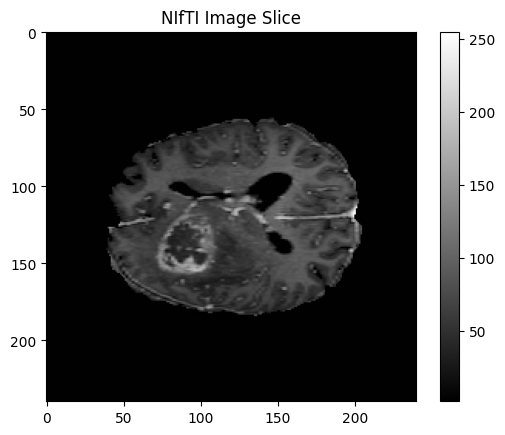

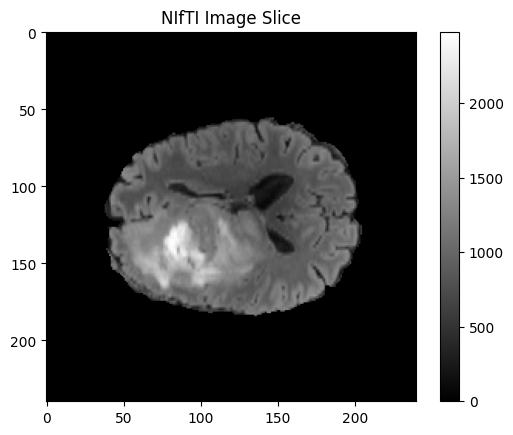

In [4]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI image
nii_file = "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1c.nii.gz"
nii_data = nib.load(nii_file).get_fdata()
print(nii_data.shape)
# Plot a slice of the NIfTI image
slice_index = nii_data.shape[2] // 2  # Choose a slice in the middle
plt.imshow(nii_data[:, :, 87], cmap='gray')
plt.title("NIfTI Image Slice")
plt.colorbar()
plt.show()
nii_file = "/kaggle/input/brats2023-part-1/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2f.nii"
nii_data = nib.load(nii_file).get_fdata()

# Plot a slice of the NIfTI image
slice_index = nii_data.shape[2] // 2  # Choose a slice in the middle
plt.imshow(nii_data[:, :, 87], cmap='gray')
plt.title("NIfTI Image Slice")
plt.colorbar()
plt.show()

In [3]:
!pip install monai
!python3 -c "import monai" || pip3 install -q "monai-weekly[nibabel, tqdm, skimage]"
!python3 -c "import matplotlib" || pip3 install -q matplotlib
!pip3 install -q pytorch-lightning==2.1.3
%matplotlib inline














   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:0000:010:01



2024-03-30 14:14:40.991992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-30 14:14:40.992097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-30 14:14:41.129093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!pip install einops




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00




In [7]:
import pytorch_lightning

import monai
import numpy as np
import pandas as pd

from typing import Union
from PIL import Image
from monai.utils import set_determinism
from monai.utils.enums import MetricReduction
from monai.transforms import (
    AsDiscrete,
    ScaleIntensityRangePercentilesd,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    MapTransform,
    Activations,
    Activationsd,
    Invertd,
    NormalizeIntensityd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    EnsureTyped,
    SpatialPadd,
    SaveImage,
    RandRotate90d,
    ConcatItemsd,
    DeleteItemsd,
)
from monai.networks.utils import one_hot
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,HausdorffDistanceMetric,ConfusionMatrixMetric, compute_hausdorff_distance, CumulativeIterationMetric
from monai.losses import DiceCELoss,DiceLoss, TverskyLoss
from monai.inferers import sliding_window_inference

from monai.data import PersistentDataset, list_data_collate, decollate_batch, DataLoader, load_decathlon_datalist, CacheDataset # NiftiSaver

from monai.config import print_config
from monai.apps import download_and_extract,DecathlonDataset
from monai.handlers.utils import from_engine

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nibabel as nib

from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.timer import Timer


print_config()

MONAI version: 1.3.0

Numpy version: 1.26.4

Pytorch version: 2.1.2

MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False

MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e

MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py



Optional dependencies:

Pytorch Ignite version: 0.4.13

ITK version: NOT INSTALLED or UNKNOWN VERSION.

Nibabel version: 5.2.1

scikit-image version: 0.22.0

scipy version: 1.12.0

Pillow version: 9.5.0

Tensorboard version: 2.15.1

gdown version: NOT INSTALLED or UNKNOWN VERSION.

TorchVision version: 0.16.2

tqdm version: 4.66.1

lmdb version: NOT INSTALLED or UNKNOWN VERSION.

psutil version: 5.9.3

pandas version: 2.2.1

einops version: 0.7.0

transformers version: 4.38.2

mlflow version: NOT INSTALLED or UNKNOWN VERSION.

pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

clearml version: NOT INSTALLED or UNKNOWN VERSION.



For details about installing the optional dependencies, please visit:

    https://do

In [8]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.3.0

Numpy version: 1.26.4

Pytorch version: 2.1.2

MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False

MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e

MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py



Optional dependencies:

Pytorch Ignite version: 0.4.13

ITK version: NOT INSTALLED or UNKNOWN VERSION.

Nibabel version: 5.2.1

scikit-image version: 0.22.0

scipy version: 1.12.0

Pillow version: 9.5.0

Tensorboard version: 2.15.1

gdown version: NOT INSTALLED or UNKNOWN VERSION.

TorchVision version: 0.16.2

tqdm version: 4.66.1

lmdb version: NOT INSTALLED or UNKNOWN VERSION.

psutil version: 5.9.3

pandas version: 2.2.1

einops version: 0.7.0

transformers version: 4.38.2

mlflow version: NOT INSTALLED or UNKNOWN VERSION.

pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

clearml version: NOT INSTALLED or UNKNOWN VERSION.



For details about installing the optional dependencies, please visit:

    https://do

In [14]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg

rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]




class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    patch_size: Final[int] = 2



    @deprecated_arg(
        name="img_size",
        since="1.3",
        removed="1.5",
        msg_suffix="The img_size argument is not required anymore and "
        "checks on the input size are run during forward().",
    )
    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            img_size: spatial dimension of input image.
                This argument is only used for checking that the input image size is divisible by the patch size.
                The tensor passed to forward() can have a dynamic shape as long as its spatial dimensions are divisible by 2**5.
                It will be removed in an upcoming version.
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dims.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beggining of each swin stage.

        Examples::

            # for 3D single channel input with size (96,96,96), 4-channel output and feature size of 48.
            >>> net = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=4, feature_size=48)

            # for 3D 4-channel input with size (128,128,128), 3-channel output and (2,4,2,2) layers in each stage.
            >>> net = SwinUNETR(img_size=(128,128,128), in_channels=4, out_channels=3, depths=(2,4,2,2))

            # for 2D single channel input with size (96,96), 2-channel output and gradient checkpointing.
            >>> net = SwinUNETR(img_size=(96,96), in_channels=3, out_channels=2, use_checkpoint=True, spatial_dims=2)

        """

        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        self._check_input_size(img_size)

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_sizes,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)



    def load_from(self, weights):
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )

    @torch.jit.unused
    def _check_input_size(self, spatial_shape):
        img_size = np.array(spatial_shape)
        remainder = (img_size % np.power(self.patch_size, 5)) > 0
        if remainder.any():
            wrong_dims = (np.where(remainder)[0] + 2).tolist()
            raise ValueError(
                f"spatial dimensions {wrong_dims} of input image (spatial shape: {spatial_shape})"
                f" must be divisible by {self.patch_size}**5."
            )


    def forward(self, x_in):
        if not torch.jit.is_scripting():
            self._check_input_size(x_in.shape[2:])
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits





def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=3,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


def filter_swinunetr(key, value):
    """
    A filter function used to filter the pretrained weights from [1], then the weights can be loaded into MONAI SwinUNETR Model.
    This function is typically used with `monai.networks.copy_model_state`
    [1] "Valanarasu JM et al., Disruptive Autoencoders: Leveraging Low-level features for 3D Medical Image Pre-training
    <https://arxiv.org/abs/2307.16896>"

    Args:
        key: the key in the source state dict used for the update.
        value: the value in the source state dict used for the update.

    Examples::

        import torch
        from monai.apps import download_url
        from monai.networks.utils import copy_model_state
        from monai.networks.nets.swin_unetr import SwinUNETR, filter_swinunetr

        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, feature_size=48)
        resource = (
            "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
        )
        ssl_weights_path = "./ssl_pretrained_weights.pth"
        download_url(resource, ssl_weights_path)
        ssl_weights = torch.load(ssl_weights_path)["model"]

        dst_dict, loaded, not_loaded = copy_model_state(model, ssl_weights, filter_func=filter_swinunetr)

    """
    if key in [
        "encoder.mask_token",
        "encoder.norm.weight",
        "encoder.norm.bias",
        "out.conv.conv.weight",
        "out.conv.conv.bias",
    ]:
        return None

    if key[:8] == "encoder.":
        if key[8:19] == "patch_embed":
            new_key = "swinViT." + key[8:]
        else:
            new_key = "swinViT." + key[8:18] + key[20:]

        return new_key, value
    else:
        return None

In [6]:
import os
import glob
import json
from monai.transforms import LoadImaged

file_paths1 = glob.glob('/kaggle/working/bratsFilteredCompressed' + "/*")
file_paths1.sort()
file_names1 = os.listdir('/kaggle/working/bratsFilteredCompressed')
file_names1.sort()

t1c, t1n, t2f, t2w, label = [], [], [], [], []
for i in range(625):
    t1c.append(os.path.join(file_paths1[i], file_names1[i] + '-t1c.nii.gz'))
    t1n.append(os.path.join(file_paths1[i], file_names1[i] + '-t1n.nii.gz'))
    t2f.append(os.path.join(file_paths1[i], file_names1[i] + '-t2f.nii.gz'))
    t2w.append(os.path.join(file_paths1[i], file_names1[i] + '-t2w.nii.gz'))
    label.append(os.path.join(file_paths1[i], file_names1[i] + '-seg.nii.gz'))

data = {
    't1c': t1c,
    't1n': t1n,
    't2f': t2f,
    't2w': t2w,
    'label': label
}

file = []
for i in range(625):
    file.append({"image": [data['t2f'][i],data['t1c'][i],data['t1n'][i], data['t2w'][i]], "label": data['label'][i]})

file_json = {
    "training": file
}

file_path = '/kaggle/working/dataset.json'
with open(file_path, 'w') as json_file:
    json.dump(file_json, json_file)

# Print file paths for debugging


slice = 100

shape = (240, 240, 155)


Text(0.5, 1.0, 'Mask')

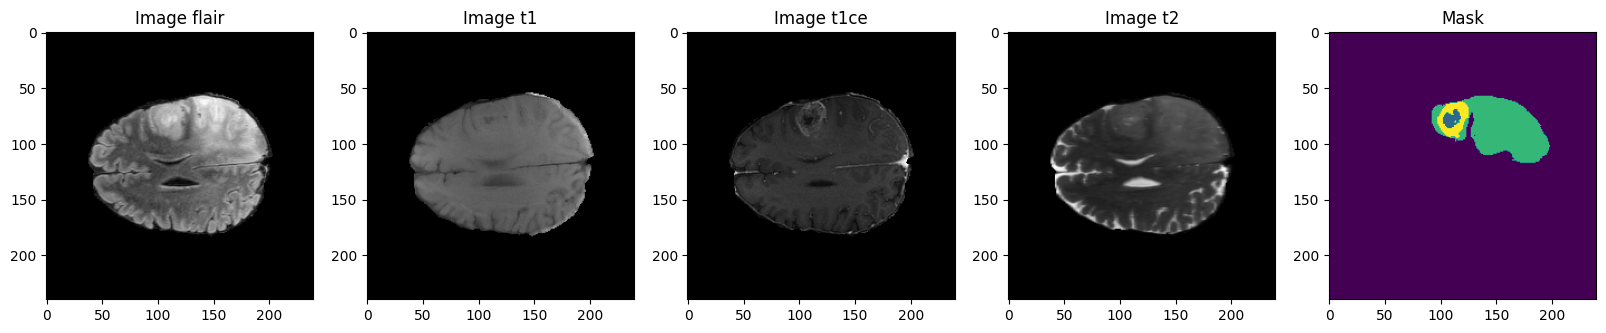

In [8]:
num = 31
flair = nib.load(data['t2f'][num]).get_fdata()
t1 = nib.load(data['t1n'][num]).get_fdata()
t1ce = nib.load(data['t1c'][num]).get_fdata()
t2 = nib.load(data['t2w'][num]).get_fdata()
mask = nib.load(data['label'][num]).get_fdata()

slice_number = 100
print('slice =', slice_number)
print('shape =', flair.shape)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
ax1.imshow(flair[:,:,slice_number], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(t1[:,:,slice_number], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(t1ce[:,:,slice_number], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(t2[:,:,slice_number], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(mask[:,:,slice_number])
ax5.set_title('Mask')

In [16]:
torch.multiprocessing.set_sharing_strategy("file_system")

In [10]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats 2023 classes:
    label 1 necrotic tumor core (NCR)
    label 2 peritumoral edematous/invaded tissue 
    label 3 GD-enhancing tumor 
    label 4 is not used in the new dataset version
    The possible classes are:
      TC (Tumor core): merge labels 1 and 3
      WT (Whole tumor): merge labels 1,2 and 3
      ET (Enhancing tumor): label 3

    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 1, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 3
                )
            )
            # label 3 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).astype(np.float32)
        return d

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        epsilon = 1e-7  # or any small value appropriate for your application
        self.avg = np.where(self.count > 0, self.sum / (self.count), self.sum)


In [18]:

def save_checkpoint(model, epoch, filename="model100.pt", best_acc=0, dir_add="/kaggle/working/"):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [19]:
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from monai.transforms import Compose, LoadImaged, \
    CropForegroundd, RandSpatialCropd, RandFlipd, NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd
import shutil  # استيراد وحدة التحكم بالملفات والمجلدات
from monai import data

def get_loader(batch_size, json_list, roi):
    
    json_list = "/kaggle/working/dataset.json"
    datalist = load_decathlon_datalist(json_list, True, "training")   
    train_files, val_files = datalist[:300], datalist[300:310]

        # setting deterministic training for reproducibility
    set_determinism(seed=0)

    # defining the data transforms
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
                allow_smaller=True  # Explicitly set allow_smaller to True

            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

   #persistent_cache = os.path.join(tempfile.mkdtemp(), "persistent_cache")

    #train_ds = monai.data.PersistentDataset(data=train_files, transform=train_transform,cache_dir=persistent_cache,)
    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    #val_ds = monai.data.PersistentDataset(data=val_files, transform=val_transform,cache_dir=persistent_cache,)
    val_ds = data.Dataset(data=val_files, transform=val_transform)
    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    return train_loader, val_loader

In [20]:
json_list = "/kaggle/working/dataset.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 1
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 2
train_loader, val_loader = get_loader(batch_size,json_list, roi)

In [21]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)
#model.load_state_dict(torch.load(os.path.join("/kaggle/input/data-nour3/model3.pt"))["state_dict"])
#model.to(device)

In [18]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [19]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
        
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [22]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Sat Mar 30 01:16:12 2024 Epoch: 0

Epoch 0/100 0/300 loss: 0.9110 time 6.42s

Epoch 0/100 1/300 loss: 0.9555 time 1.83s

Epoch 0/100 2/300 loss: 0.9239 time 1.89s

Epoch 0/100 3/300 loss: 0.9280 time 1.83s

Epoch 0/100 4/300 loss: 0.9411 time 1.85s

Epoch 0/100 5/300 loss: 0.9393 time 1.84s

Epoch 0/100 6/300 loss: 0.9376 time 1.83s

Epoch 0/100 7/300 loss: 0.9453 time 1.83s

Epoch 0/100 8/300 loss: 0.9428 time 1.84s

Epoch 0/100 9/300 loss: 0.9399 time 1.83s

Epoch 0/100 10/300 loss: 0.9438 time 1.84s

Epoch 0/100 11/300 loss: 0.9470 time 1.83s

Epoch 0/100 12/300 loss: 0.9466 time 1.84s

Epoch 0/100 13/300 loss: 0.9423 time 1.84s

Epoch 0/100 14/300 loss: 0.9447 time 1.84s

Epoch 0/100 15/300 loss: 0.9441 time 1.84s

Epoch 0/100 16/300 loss: 0.9456 time 1.84s

Epoch 0/100 17/300 loss: 0.9392 time 1.84s

Epoch 0/100 18/300 loss: 0.9414 time 1.84s

Epoch 0/100 19/300 loss: 0.9422 time 1.83s

Epoch 0/100 20/300 loss: 0.9445 time 1.84s

Epoch 0/100 21/300 loss: 0.9404 time 1.84s

Epoch 0

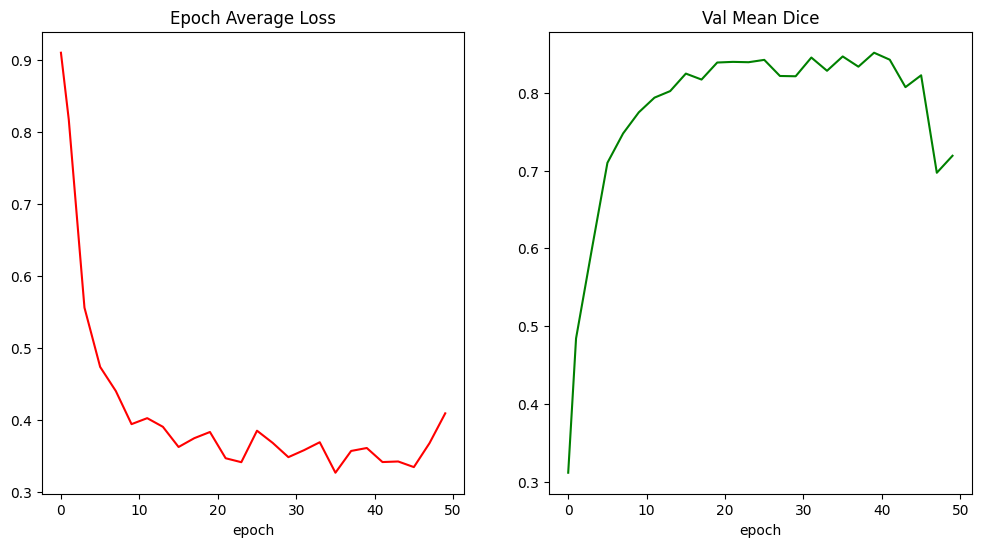

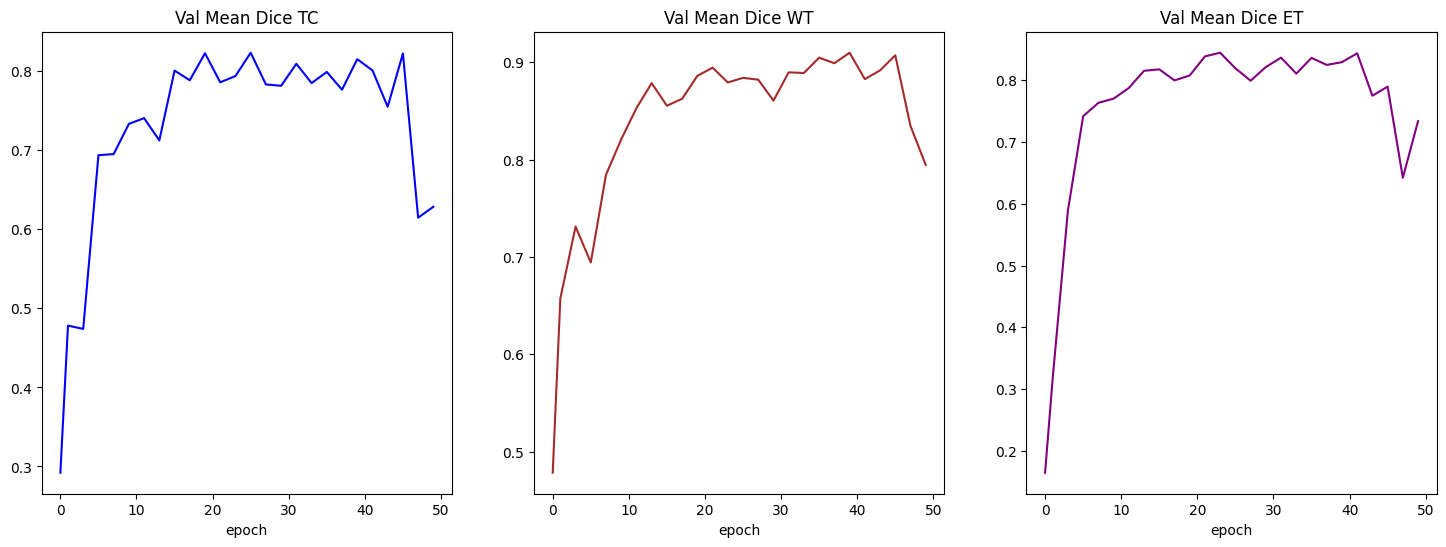

In [2]:
import matplotlib.pyplot as plt
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.savefig("EpochAverageLoss_ValMeanDice100_85.png")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.savefig("Haursdoff_Dice_class100_85.png")
plt.show()

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Fri Mar 29 03:36:33 2024 Epoch: 0

Epoch 0/70 0/300 loss: 0.1293 time 6.43s

Epoch 0/70 1/300 loss: 0.2502 time 1.88s

Epoch 0/70 2/300 loss: 0.3155 time 1.84s

Epoch 0/70 3/300 loss: 0.3185 time 1.84s

Epoch 0/70 4/300 loss: 0.3128 time 1.84s

Epoch 0/70 5/300 loss: 0.4054 time 1.91s

Epoch 0/70 6/300 loss: 0.4064 time 1.84s

Epoch 0/70 7/300 loss: 0.4170 time 1.84s

Epoch 0/70 8/300 loss: 0.4062 time 1.84s

Epoch 0/70 9/300 loss: 0.3943 time 1.84s

Epoch 0/70 10/300 loss: 0.3888 time 1.84s

Epoch 0/70 11/300 loss: 0.3842 time 1.84s

Epoch 0/70 12/300 loss: 0.3843 time 1.84s

Epoch 0/70 13/300 loss: 0.3988 time 1.84s

Epoch 0/70 14/300 loss: 0.3927 time 1.84s

Epoch 0/70 15/300 loss: 0.3771 time 1.84s

Epoch 0/70 16/300 loss: 0.3794 time 1.84s

Epoch 0/70 17/300 loss: 0.3839 time 1.84s

Epoch 0/70 18/300 loss: 0.3756 time 1.84s

Epoch 0/70 19/300 loss: 0.3735 time 1.84s

Epoch 0/70 20/300 loss: 0.3738 time 1.84s

Epoch 0/70 21/300 loss: 0.3590 time 1.84s

Epoch 0/70 22/300 loss: 0.377

In [28]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-t2f.nii.gz",
            ),
            os.path.join(
                "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-t1c.nii.gz",
            ),
            os.path.join(
                "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-t1n.nii.gz",
            ),
            os.path.join(
                "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-t2w.nii.gz",
            ),
        ],
        "label": os.path.join(
            "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [29]:
model.load_state_dict(torch.load(os.path.join("/kaggle/working/model100.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        print(seg.shape)
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4


(3, 240, 240, 155)


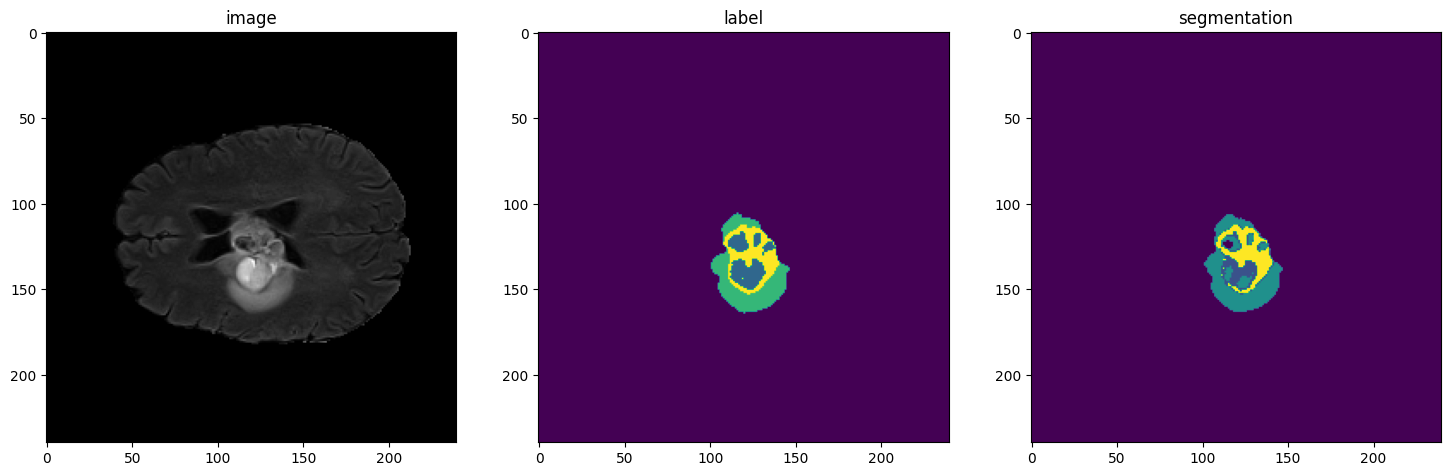

In [30]:
slice_num = 87
img_add = os.path.join(
    "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-t2f.nii.gz",
)
label_add = os.path.join(
    "/kaggle/working/bratsFilteredCompressed/BraTS-GLI-00165-000/BraTS-GLI-00165-000-seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [75]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats 2023 classes:
    label 1 necrotic tumor core (NCR)
    label 2 peritumoral edematous/invaded tissue 
    label 3 GD-enhancing tumor 
    The possible classes are:
      TC (Tumor core): merge labels 1 and 3
      WT (Whole tumor): merge labels 1,2 and 3
      ET (Enhancing tumor): label 3

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 1, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 3
                )
            )
            # label 3 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).astype(np.float32)
        return d

0


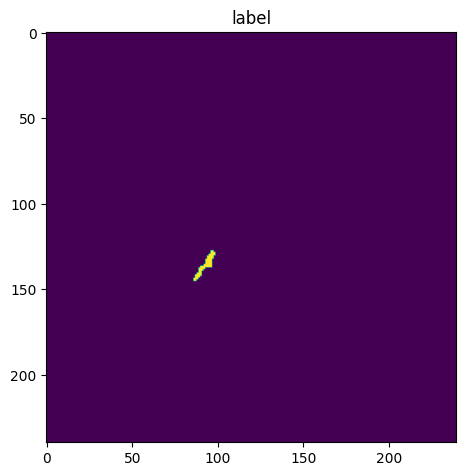

1


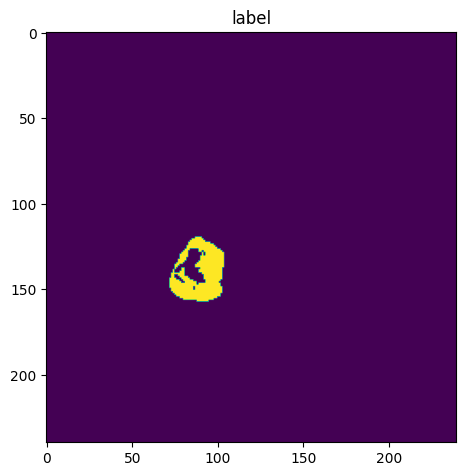

2


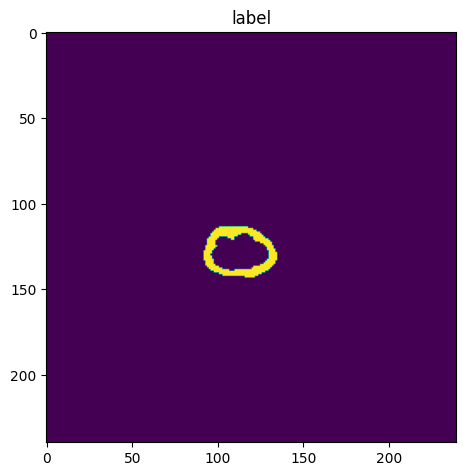

3


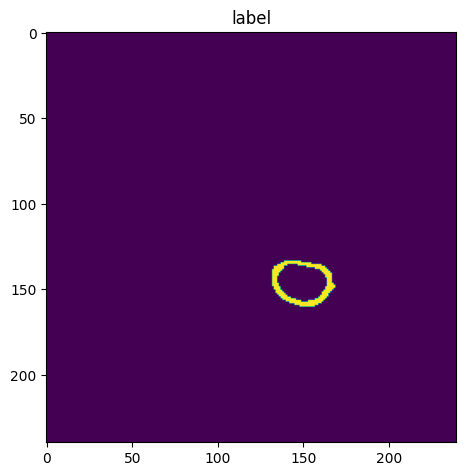

4


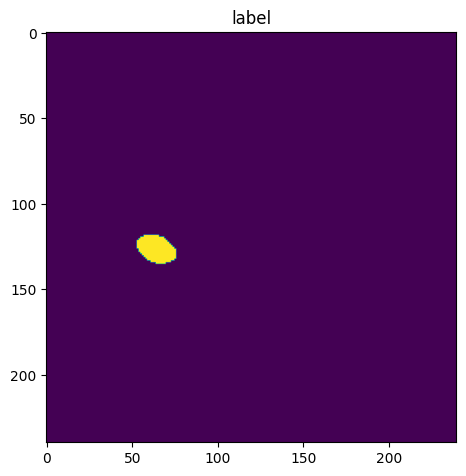

5


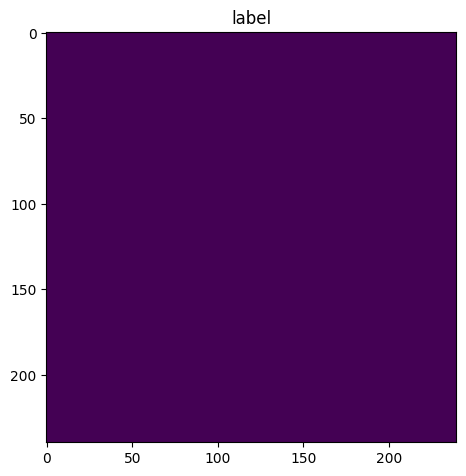

6


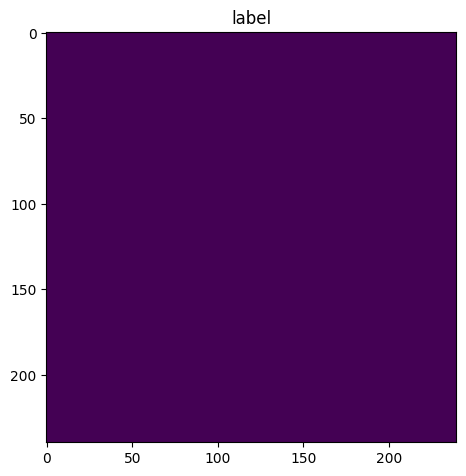

7


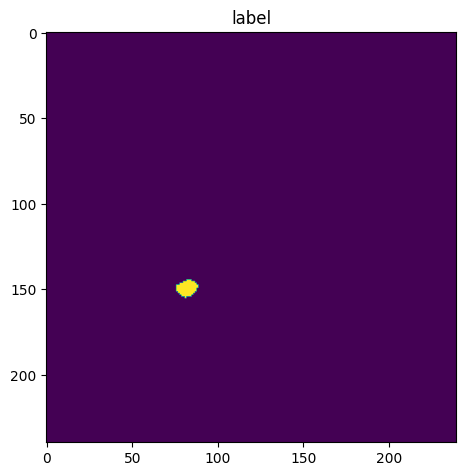

8


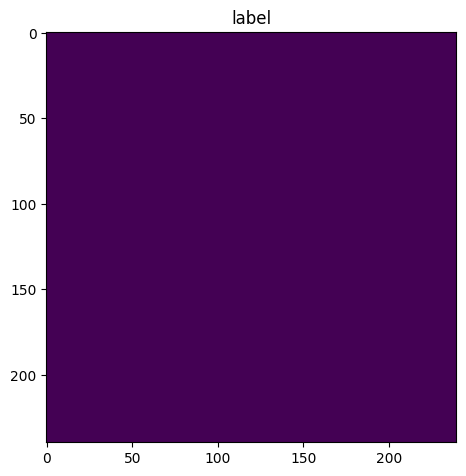

9


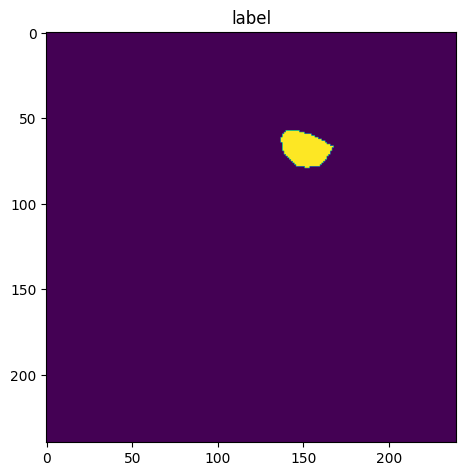

10


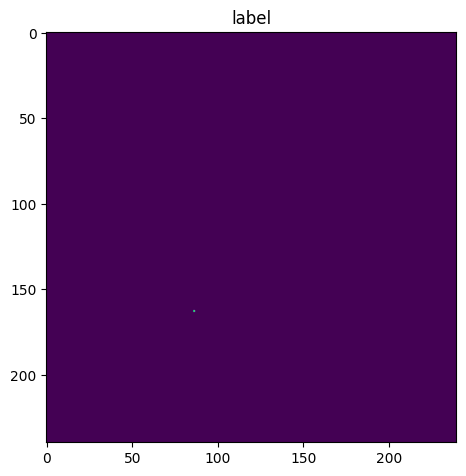

11


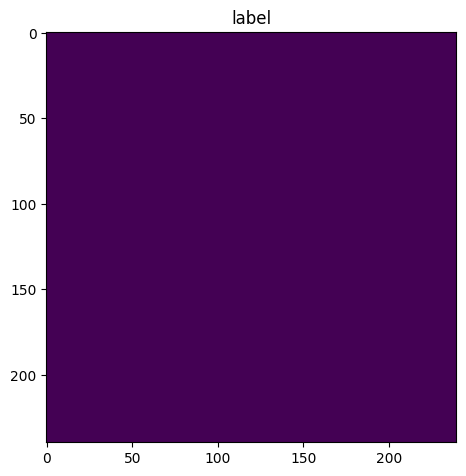

In [76]:
from functools import partial
import os
import tempfile
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import monai
from monai.data import load_decathlon_datalist, PersistentDataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, ConcatItemsd, DeleteItemsd, Spacingd, NormalizeIntensityd
from monai import transforms
# Load your model and define other necessary variables
# ...
from monai import data

from functools import partial
roi = (128, 128, 128)
roi_size = (128, 128, 128)
sw_batch_size = 1
datasets = "/kaggle/working/dataset.json"
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = datalist[:12]

from monai.transforms import Compose, LoadImaged, NormalizeIntensityd

from monai.transforms import Compose, LoadImaged, NormalizeIntensityd

# Define a custom transform to split the "wt" class into "wt" and "et" classe

# Define the transformation pipeline
val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),

])



val_ds = data.Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

size = 90 # Select the slice number

for case_num in range(len(val_ds)):
    with torch.no_grad():
        print(case_num)
        image, label = val_ds[case_num]["image"], val_ds[case_num]["label"]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"label")
        plt.imshow(label[2, :, :, 90])

        plt.show()

